<a href="https://colab.research.google.com/github/nicolassalomon96/procesamiento_imagenes_UNS/blob/main/TP4/Histograma_de_luminancia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP4 - Histograma de Luminancias

### Presentado: Nicolás Salomón - email: nicolassalomon96@gmail.com

* Generar una función que como parámetro de entrada tome la luminacia de una imagen y un numero entero de contadores y como salida obtengamos el histograma respectivo. Mostrar el histograma respectivo para 5 valores de contadores diferentes.

* Buscar dos imágenes con problemas de iluminación (una oscura y otra muy brillante, como las mostradas en las filminas de la clase Pag. 7). Verificar la premisa de que al multiplicar la luminancia por un valor alfa, el problema de iluminación no se corrige. Mostrar la imagen original, la resultante y sus respectivos histogramas, para un valor alfa dado.

* Implementar las funciones: Lineal a trozos para un valor Y_min y Y_max como parámetros de la función, raíz cuadrada y potencia cuadrática. Para estas usar las imágenes anteriores y mostrar cómo cambio la imagen y el histograma después de aplicar el filtro a la imagen.

## 1. Librerias necesarias

In [1]:
import os
import numpy as np
import imageio as io
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

## 2. Funciones necesarias

In [2]:
#Función para descargar imagen
def get_image(path):
  image = io.imread(path)
  image = image/255
  return image

#Función para mostrar una imagen RGB
def plot_image(image,title,figsize=(15,15)):
  fig, ax = plt.subplots(figsize=figsize)
  plt.imshow(image)
  plt.title(title)
  plt.show()

#Función para separar los canales Y, I y Q
def split_YIQ(YIQ):
  Y = YIQ[:,:,0]
  I = YIQ[:,:,1]
  Q = YIQ[:,:,2]
  return Y, I, Q

#Función para clipear valores del espacio YIQ
def yiq_clip(Y, I, Q):
  Y = np.clip(Y, 0, 1)
  I = np.clip(I, -0.5957, 0.5957)
  Q = np.clip(Q, -0.5226, 0.5226)
  return Y, I, Q

#Función para clipear valores del espacio RGB
def rgb_clip(R, G, B):
  R = np.clip(R, 0, 1)
  G = np.clip(G, 0, 1)
  B = np.clip(B, 0, 1)
  #Se convierten los valores a byte (valores enteros de 0 a 255)
  R = (R*255).astype(int)
  G = (G*255).astype(int)
  B = (B*255).astype(int)    
  return R, G, B

#Funcion para crear un botón de guardado
def save_button(image,full_path):
  '''
  input: image=arreglo numpy obtenido luego de leer una imagen
         full_path=ruta completa de guardado (incluido nombre y extensión)
  '''
  #Función para guardar una imagen
  def save_image(image,full_path):
    image = np.uint8(image)
    io.imsave(full_path,image)
 
  my_button = widgets.Button(description='SAVE IMAGE')
  out = widgets.Output()

  def on_button_clicked(b):
     with out:
      #Que sucede al presionar el boton
      save_image(image,full_path)      
    
  my_button.on_click(on_button_clicked)
  display(my_button,out)

#Función para convertir una imagen del espacio RGB al YIQ
def rgb2yiq(RGB):
    '''
    input: matriz de la imagen en formato RGB normalizada
    output: matriz de la imagen en formato YIQ
    '''
    rgb2yiq_matrix = np.array([[0.299,0.587,0.114],[0.595716,-0.274453,-0.321263],[0.211456,-0.522591,0.311135]])
    #print("Matriz de conversion RGB a YIQ:")
    #print(rgb2yiq_matrix)

    #Se normalizan los valores de RGB entre 0.0 y 1.0 (ya estan normalizados al momento de leer la imagen)
    #RGB = RGB/255 

    Y = rgb2yiq_matrix[0][0] * RGB[:,:,0] + rgb2yiq_matrix[0][1] * RGB[:,:,1] + rgb2yiq_matrix[0][2] * RGB[:,:,2]
    I = rgb2yiq_matrix[1][0] * RGB[:,:,0] + rgb2yiq_matrix[1][1] * RGB[:,:,1] + rgb2yiq_matrix[1][2] * RGB[:,:,2]
    Q = rgb2yiq_matrix[2][0] * RGB[:,:,0] + rgb2yiq_matrix[2][1] * RGB[:,:,1] + rgb2yiq_matrix[2][2] * RGB[:,:,2]

    Y, I, Q = yiq_clip(Y, I, Q)
    
    YIQ = np.dstack((Y,I,Q))
    
    return YIQ

#Función para convertir una imagen del espacio YIQ al RGB 
def yiq2rgb(YIQ):
    '''
    input: matriz de la imagen en formato YIQ 
    output: matriz de la imagen en formato RGB (en bytes)
    '''
    yiq2rgb_matrix = np.array([[1,0.9663,0.6210],[1,-0.2721,-0.6474],[1,-1.1070,1.7046]])
    #print("Matriz de conversion YIQ a RGB:")
    #print(yiq2rgb_matrix)

    R = yiq2rgb_matrix[0][0] * YIQ[:,:,0] + yiq2rgb_matrix[0][1] * YIQ[:,:,1] + yiq2rgb_matrix[0][2] * YIQ[:,:,2]
    G = yiq2rgb_matrix[1][0] * YIQ[:,:,0] + yiq2rgb_matrix[1][1] * YIQ[:,:,1] + yiq2rgb_matrix[1][2] * YIQ[:,:,2]
    B = yiq2rgb_matrix[2][0] * YIQ[:,:,0] + yiq2rgb_matrix[2][1] * YIQ[:,:,1] + yiq2rgb_matrix[2][2] * YIQ[:,:,2]

    R, G, B = rgb_clip(R, G, B)  
    
    RGB = np.dstack((R,G,B))
    
    return RGB  

#Función para generar el histograma de luminancia de la imagen
def generate_histo(Y, min, max, steps):
  
  bins = np.round(np.linspace(min, max, steps+1),6) #Genera las divisiones en base al número de contadores
  #Aclaración: se redondea a 6 decimales como máximo para evitar errores debido a la representación de los números con punto flotante
  counts, bins_edges = np.histogram(Y, bins)

  #Cálculo de la frecuencia relativa para generar el histograma de frecuencia
  total_counts = sum(counts)
  counts_relative_freq = np.round(((counts*100)/total_counts),2)
  return counts_relative_freq, bins_edges

#Función para plotear el histograma de frecuencias relativas
def plot_histo(counts_relative_freq, bins, steps, figsize=(15,6)):
  
  plt.figure(figsize=figsize)
  plt.hist(bins[:-1], bins, weights=counts_relative_freq, ec='black')
  plt.title("Histograma de Luminancia")
  plt.xlabel("Luminancias")
  plt.ylabel("Frecuencia %")
  plt.xticks(np.arange(0,1.01,1/steps))
  
  plt.show()  

#Función para plotear una imagen y su histograma en la misma figura
def plot_image_histo(image, counts_relative_freq, bins, steps, figsize=(25,8)):

  fig, axs = plt.subplots(1,2,figsize=figsize)
  
  plt.subplot(1,2,1)
  plt.imshow(image)
  plt.title("Imagen")
  
  plt.subplot(1,2,2)
  plt.hist(bins[:-1], bins, weights=counts_relative_freq, ec='black')
  plt.title("Histograma de Luminancia")
  plt.xlabel("Luminancias",fontsize=18)
  plt.ylabel("Frecuencia %",fontsize=18)
  plt.xticks(np.arange(0,1.01,1/steps))

  plt.tight_layout()
  plt.show()

# Función para aplicar un filtro cuadrático a la imagen
def sqr_filter(image):
  YIQ = rgb2yiq(image)
  Y, I, Q = split_YIQ(YIQ)
  Y_new = Y * Y
  YIQ_new = np.dstack((Y_new,I,Q))
  return YIQ_new

# Función para aplicar un filtro raíz cuadrada a la imagen
def sqrt_filter(image):
  YIQ = rgb2yiq(image)
  Y, I, Q = split_YIQ(YIQ)
  Y_new = Y ** 0.5
  YIQ_new = np.dstack((Y_new,I,Q))
  return YIQ_new

#Función para aplicar filtro lineal 
def lineal_filter(image, y_in_min, y_in_max):
  y_out_min = 0
  y_out_max = 1

  #Ecuación de la recta: y-y1 = m(x-x1) --> y = mx + b
  m = (y_out_max - y_out_min)/(y_in_max - y_in_min) #pendiente entre (y_in_min e y_in_max)
  b = y_out_min - m * y_in_min #ordenada al origen
  
  image_yiq = rgb2yiq(image)
  Y, I, Q = split_YIQ(image_yiq)

  print(f"Valor pixel antes de modificar: {Y[337][337]}")

  Y[Y < y_in_min] = 0
  Y[Y > y_in_max] = 1
  Y = np.where((Y >= y_in_min) & (Y <= y_in_max), m * Y + b, Y)

  print(f"Valor pixel despues de modificar: {Y[337][337]}")

  image_yiq_mod = np.dstack((Y, I, Q))
  return image_yiq_mod


#Función para plotear una función cuadratica
def plot_sqr_function(xmin, xmax):
  x = np.arange(xmin, xmax + 0.01, 0.01)
  plt.figure(figsize=(10,6))
  plt.plot(x, x**2)
  plt.title("Función: sqr")
  plt.show()

#Función para plotear una función raíz cuadrada
def plot_sqrt_function(xmin, xmax):
  x = np.arange(xmin, xmax + 0.01, 0.01)
  plt.figure(figsize=(10,6))
  plt.plot(x, x**0.5)
  plt.title("Función: sqrt")
  plt.show()

#Función para plotear una función lineal a trozoa
def plot_lineal_function(xmin, xmax, y_in_min, y_in_max):
  
  steps = 0.01
  x1 = np.arange(xmin, y_in_min, steps)
  x2 = np.arange(y_in_min, y_in_max, steps)
  x3 = np.arange(y_in_max + steps, xmax + steps, steps)
  
  y1 = np.zeros(len(x1))
  y2 = np.arange(xmin, xmax, (xmax - xmin)/len(x2))
  y3 = np.ones(len(x3))

  x = np.concatenate((x1,x2,x3))
  y = np.concatenate((y1,y2,y3))

  plt.figure(figsize=(10,6))
  plt.plot(x, y)
  plt.title("Función: lineal")
  plt.show()


## 3. Selección de la imagen y muestra de su histograma

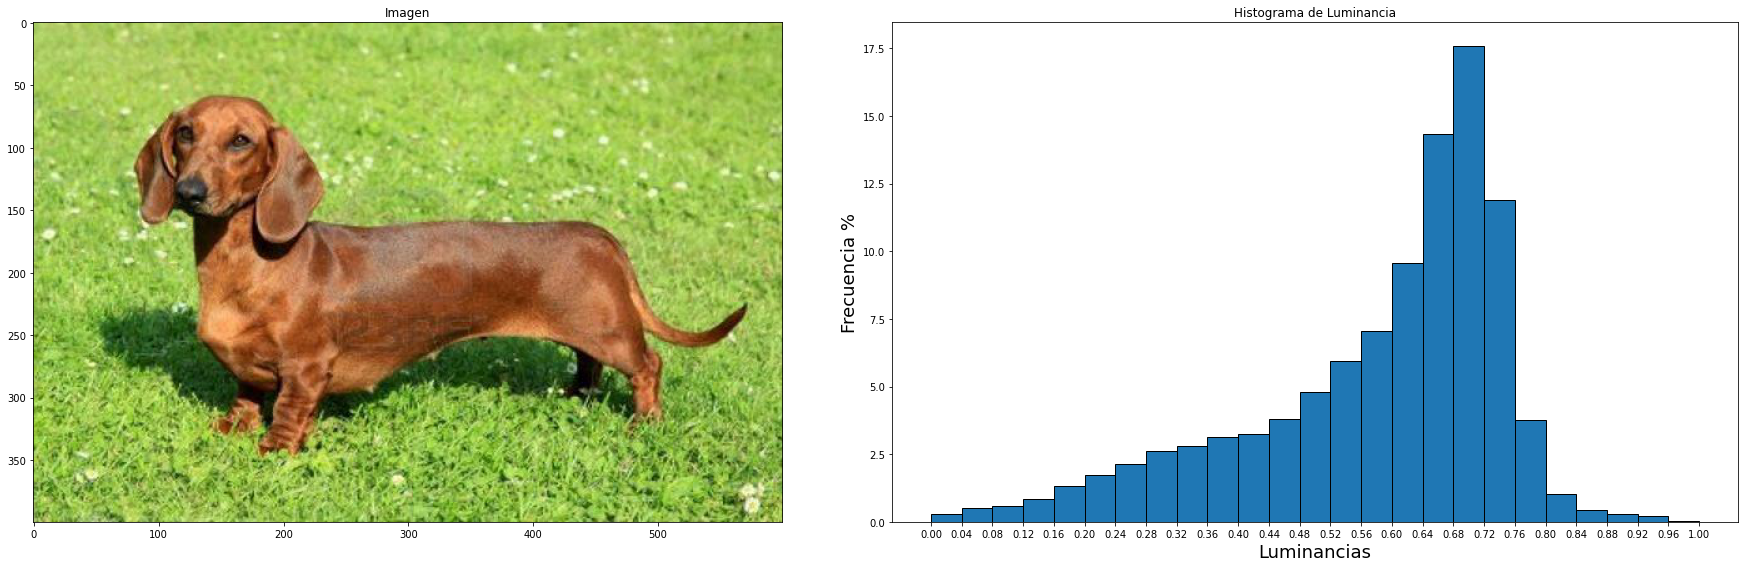

In [3]:
#@title Seleccione la imagen a analizar: { run: "auto" }
dog_url = 'https://pbs.twimg.com/media/BwURyszIYAEtRva.jpg'
route_url = 'https://cdn1.eldia.com/122017/1514109535760.jpg'
lake_url = 'https://s1.1zoom.me/prev/596/USA_Mountains_Lake_Forests_Sky_Lake_Dillon_Clouds_595131_600x400.jpg'

Imagen = 'Perro' #@param ["Perro","Lago","Ruta"]

if Imagen =='Perro':
  image_1 = get_image(dog_url)
if Imagen =='Lago':
  image_1 = get_image(lake_url)
if Imagen =='Ruta':
  image_1 = get_image(route_url)   

#@title Seleccione la cantidad de contadores: { run: "auto" }

Contadores = 25 #@param {type:"slider", min:1, max:50, step:1}
image_1_y = rgb2yiq(image_1)[:,:,0] #Extracción del canal Y (luminancia) de la imagen

counts_relative_freq, bins = generate_histo(image_1_y,0,1,Contadores)
plot_image_histo(image_1, counts_relative_freq, bins, Contadores, figsize=(25,8))

### 3.1. Muestra para 5 valores distintos de contadores

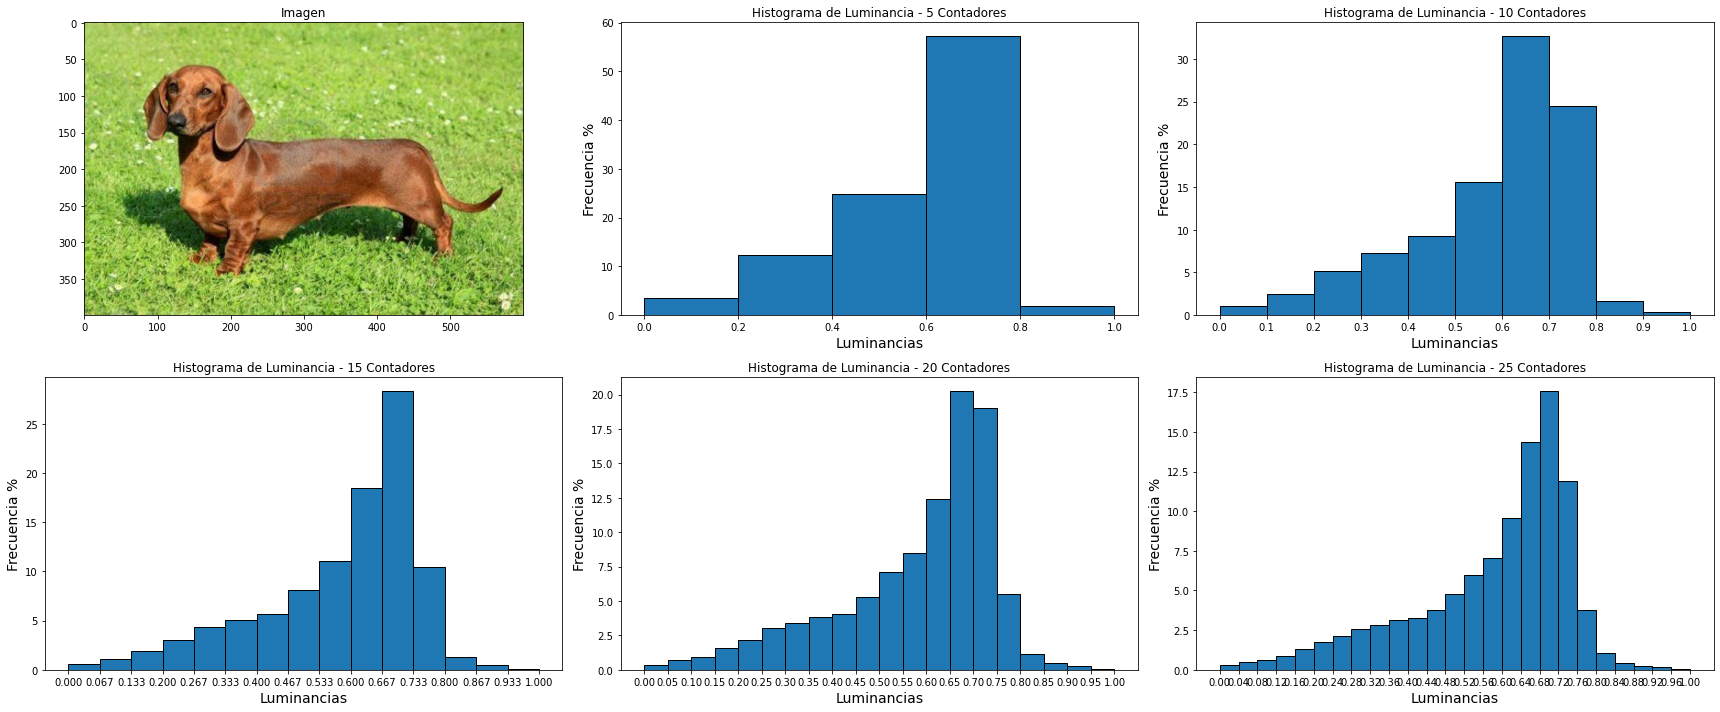

In [4]:
#@title Ingrese los 5 valores de contadores a mostrar, separados por coma (ej: 5,10,15,20,25):
#@markdown Luego de setear los contadores ejecutar la celda para ver los resultados

Contadores = '5,10,15,20,25' #@param {type:"string"}

#image_1_y = rgb2yiq(image)[:,:,0] #Extracción del canal Y (luminancia) de la imagen

fig,ax = plt.subplots(2,3,figsize=(24,10))

plt.subplot(2,3,1)
plt.imshow(image_1)
plt.title("Imagen")

for i in range(len(Contadores.split(sep=','))):
  plt.subplot(2,3,i+2)
  counts_relative_freq, bins = generate_histo(image_1_y,0,1,int(Contadores.split(sep=',')[i]))
  plt.hist(bins[:-1], bins, weights=counts_relative_freq, ec='black')
  plt.title(f"Histograma de Luminancia - {int(Contadores.split(sep=',')[i])} Contadores")
  plt.xlabel("Luminancias",fontsize=14)
  plt.ylabel("Frecuencia %",fontsize=14)
  plt.xticks(np.arange(0,1.01,1/int(Contadores.split(sep=',')[i])))

plt.tight_layout()
plt.show()

## 4. Multiplicación de la luminancia por un valor alfa determinado

Valor pixel antes de modificar: 0.7878627450980391
Valor pixel despues de modificar: 1.0


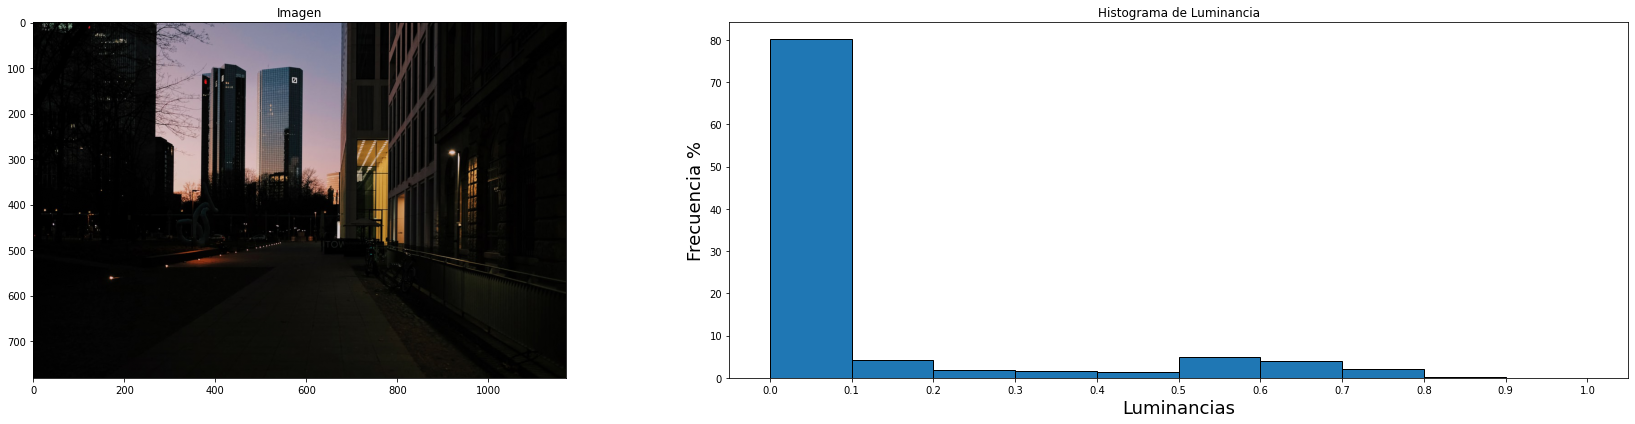

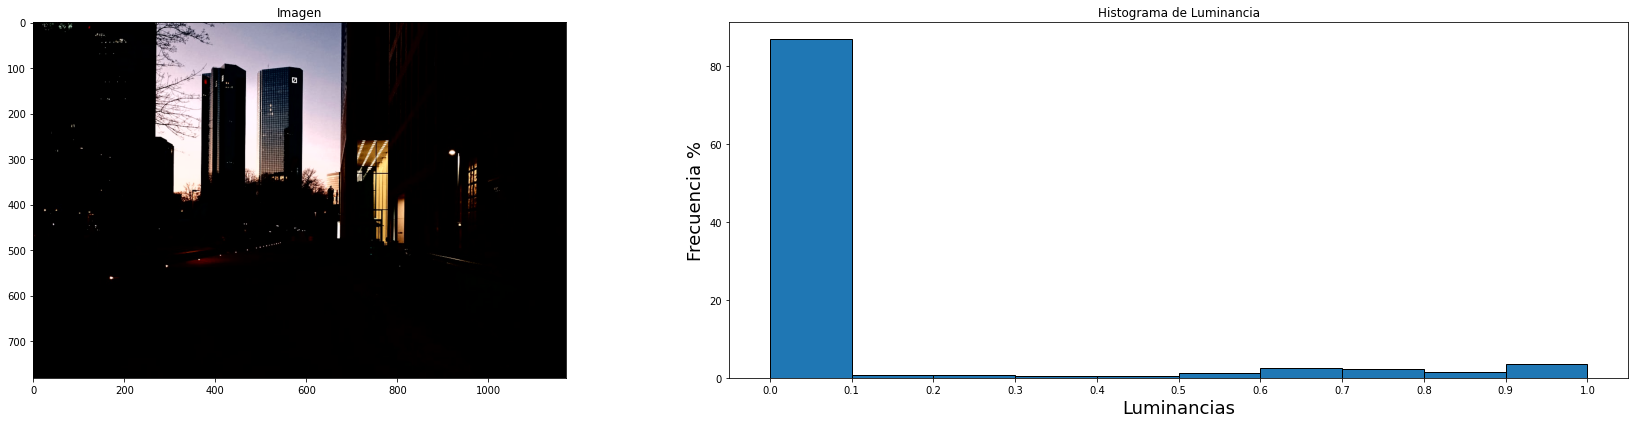

In [12]:
#@title Seleccione la imagen a analizar: { run: "auto" }
low_Y_1 = 'https://images.unsplash.com/photo-1525036984299-360cc38f470a?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MTY0fHxsb3clMjBsaWdodHxlbnwwfHwwfHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60'
low_Y_2 = 'https://images.unsplash.com/photo-1615221990091-b8203265e94c?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1171&q=80'
high_Y_1 = 'https://www.rockandpop.cl/wp-content/uploads/2020/01/photophobia.jpg'
high_Y_2 = 'https://i0.wp.com/www.iluminet.com/press/wp-content/uploads/2018/11/ugr-06.jpg?w=780&ssl=1'

Imagen = 'Baja_luminancia_2' #@param ["Baja_luminancia_1","Baja_luminancia_2","Alta_luminancia_1","Alta_luminancia_2"]

if Imagen =='Baja_luminancia_1':
  image_2 = get_image(low_Y_1)
elif Imagen =='Baja_luminancia_2':
  image_2 = get_image(low_Y_2)
elif Imagen =='Alta_luminancia_1':
  image_2 = get_image(high_Y_1)
elif Imagen =='Alta_luminancia_2':
  image_2 = get_image(high_Y_2)
else:
  print("Error")     

#@markdown Seleccione la cantidad de contadores: { run: "auto" }
Contadores_1 = 10 #@param {type:"slider", min:1, max:50, step:1}

#@markdown Seleccione la función a aplicar: { run: "auto" }
Funcion = 'Lineal' #@param ["Multiplicacion_alfa", "Potencia_cuadratica", "Raiz_cuadrada","Lineal"]

#@markdown Seleccione el valor alfa a multiplicar (en caso de haber elegido esta función): { run: "auto" }
Alfa = 2 #@param {type:"slider", min:0, max:5, step:0.1}

#@markdown Seleccione el valor mínimo y máximo de la función lineal a trozos (en caso de haber elegido esta función): { run: "auto" }
lower_y = 0.3 #@param {type:"slider", min:0, max:1, step:0.1}
upper_y = 0.7 #@param {type:"slider", min:0, max:1, step:0.1}

image_2_y, image_2_i, image_2_q = split_YIQ(rgb2yiq(image_2)) #Extracción del canal Y (luminancia) de la imagen

if Funcion == 'Multiplicacion_alfa':
  image_2_y_mod = image_2_y * Alfa
  YIQ_new = np.dstack((yiq_clip(image_2_y_mod, image_2_i, image_2_q))) #Nos aseguramos que no se salga de rango
elif Funcion == 'Potencia_cuadratica':
  YIQ_new = sqr_filter(image_2)
elif Funcion == 'Raiz_cuadrada':
  YIQ_new = sqrt_filter(image_2)
elif Funcion == 'Lineal':
  YIQ_new = lineal_filter(image_2, lower_y, upper_y)
else:
  print("Error")

counts_relative_freq, bins = generate_histo(image_2_y,0,1,Contadores_1)
plot_image_histo(image_2, counts_relative_freq, bins, Contadores_1, figsize=(25,6))

counts_relative_freq_mod, bins_mod = generate_histo(YIQ_new[:,:,0],0,1,Contadores_1)
#image_2_mod = np.dstack((image_2_y_mod, image_2_i, image_2_q))
image_2_mod_rgb = yiq2rgb(YIQ_new)
plot_image_histo(image_2_mod_rgb, counts_relative_freq_mod, bins_mod, Contadores_1, figsize=(25,6))
